# **🫁 Lung Cancer Image Classification - Preprocessing Pipeline**

## 📋 Project Overview
**Goal:** Build a deep learning model to classify lung CT scan images as **Normal** or **Malignant** (cancerous)

**This Notebook Covers:**
- ✅ Data loading and preprocessing
- ✅ Image enhancement using CLAHE
- ✅ Data augmentation strategies
- ✅ Dataset splitting (train/validation/test)
- ✅ Data visualization

---

## 🎯 Why Preprocessing Matters?
Medical images often have:
- Low contrast (hard to see differences)
- Varying sizes and orientations
- Different brightness levels

Proper preprocessing helps the model learn better patterns!

## 📦 Import Libraries

**What each library does:**

- **`torch`** - PyTorch deep learning framework
- **`torchvision`** - Image processing tools for PyTorch (datasets, transforms, models)
- **`cv2` (OpenCV)** - Computer vision library (we use it for CLAHE enhancement)
- **`PIL` (Python Imaging Library)** - Basic image loading and manipulation
- **`numpy`** - Numerical operations on arrays
- **`matplotlib/seaborn`** - Data visualization
- **`tqdm`** - Progress bars for loops (makes waiting less boring!)
- **`pandas`** - Data analysis (if needed)

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image

## ⚙️ Configuration Constants

**Why these specific values?**

- **`DATA_DIR`** - Path to your organized dataset folders (train/val/test)
  
- **`BATCH_SIZE = 32`** - Number of images processed together
  - **Why 32?** Good balance between:
    - **Memory usage** (32 images fit in most GPUs)
    - **Training speed** (processes 32 at once, faster than 1 at a time)
    - **Gradient stability** (averages over 32 samples reduces noise)
  - Common choices: 16, 32, 64, 128
  
- **`IMAGE_SIZE = 224`** - Standard input size for most pretrained models
  - **Why 224?** Most ImageNet pretrained models (ResNet, VGG, EfficientNet) expect 224×224 images
  - Using standard size lets us use transfer learning later!

In [11]:
# CONSTANTS

# DATA_DIR = "F:/Machine Learning/PyTorch/Lung_Cancer/Final_Split_Data"
DATA_DIR = "/content/drive/MyDrive/Final_Split_Data"
BATCH_SIZE = 32
IMAGE_SIZE = 224 # 224x224 image pixels


In [12]:
DATA_DIR

'/content/drive/MyDrive/Final_Split_Data'

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
print(f"🖥️  Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"⚡ CUDA Available: {torch.cuda.is_available()}")
print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Test actual speed
import time
x = torch.randn(1000, 1000).cuda()
start = time.time()
y = x @ x
torch.cuda.synchronize()
print(f"⏱️  GPU Speed Test: {(time.time()-start)*1000:.2f}ms")

🖥️  Device: Tesla T4
⚡ CUDA Available: True
📊 GPU Memory: 15.83 GB
⏱️  GPU Speed Test: 1.18ms


## 🔍 Custom CLAHE Transform

### What is CLAHE?
**CLAHE** = Contrast Limited Adaptive Histogram Equalization

### Why do we need it?
- Medical images (CT scans) often have **low contrast**
- Hard to see subtle differences between normal and cancerous tissue
- CLAHE **enhances local contrast** without over-amplifying noise

### How CLAHE works:
1. **Divides image into small tiles** (8×8 grid)
2. **Applies histogram equalization to each tile separately** (enhances local details)
3. **Limits contrast amplification** (`clip_limit=2.0` prevents noise explosion)
4. **Blends tile boundaries smoothly** (avoids checkerboard effect)

### Key Parameters:
- **`clip_limit=2.0`** - Controls maximum contrast enhancement
  - Lower = less enhancement (0.5-1.0 for subtle)
  - Higher = more enhancement (2.0-4.0 for aggressive)
  - We use 2.0 as a balanced middle ground
  
- **`tile_grid_size=(8, 8)`** - Divides image into 8×8 = 64 tiles
  - Smaller tiles (4×4) = more local enhancement
  - Larger tiles (16×16) = more global enhancement

### Why LAB Color Space for RGB images?
- LAB separates **luminance (L)** from **color (A, B)**
- We only enhance luminance channel → preserves original colors
- Converts: RGB → LAB → Enhance L → RGB

In [15]:
class ApplyCLAHE:
    def __init__(self, clip_limit=1, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):

        # convert PIL image to numpy array
        img_np = np.array(img)

        # apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

        # if gray scale
        if len(img_np.shape) == 2:
            img_clahe = clahe.apply(img_np)

        # if RGB, apply to each channel
        else:
            img_clahe = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            img_clahe[:, :, 0] = clahe.apply(img_clahe[:, :, 0])
            img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2RGB)

        return Image.fromarray(img_clahe)

## 🔄 Training Data Transforms (with Augmentation)

### Transform Pipeline Explained:

**1. `Grayscale(num_output_channels=1)`** - Convert to grayscale
   - **Why?** Lung CT scans don't need color, tissue structure matters more
   - Reduces data from 3 channels (RGB) to 1 channel

**2. `ApplyCLAHE(clip_limit=2.0)`** - Enhance contrast
   - Makes tissue differences more visible
   - Helps model detect subtle patterns

**3. `Grayscale(num_output_channels=3)`** - Convert back to 3-channel
   - **Why?** Pretrained models expect 3-channel input (RGB)
   - Simply triplicates the grayscale channel: [G] → [G, G, G]

**4. `Resize((234, 234))` + `RandomCrop((224, 224))`** - Augmentation!
   - Resize to slightly larger (234×234)
   - Then randomly crop to 224×224
   - **Why?** Each epoch sees different crops → model learns to be position-invariant
   - Prevents overfitting by adding variety

**5. `ToTensor()`** - Convert PIL Image → PyTorch Tensor
   - Changes range from [0, 255] → [0.0, 1.0]
   - Changes shape from (H, W, C) → (C, H, W)

**6. `Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])`**
   - **Why these numbers?** ImageNet statistics (standard for transfer learning)
   - Formula: `(pixel - mean) / std`
   - Centers data around 0, makes training more stable
   - Required if using pretrained models!

In [16]:
# tranformers (grayscale, resize, to tensor, normalize)

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE + 10, IMAGE_SIZE + 10)),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

## ✅ Validation/Test Transforms (Deterministic)

### Key Difference from Training Transforms:

**NO Random Augmentation!**
- **Training:** Uses `RandomCrop` → different crops each time
- **Val/Test:** Direct `Resize` → same image every time

### Why No Augmentation for Val/Test?
- **Consistency:** We want to evaluate model performance on same images
- **Fair comparison:** Results should be reproducible
- **Real-world simulation:** During deployment, you'll use raw images

### Transform Pipeline:
1. **Grayscale** → CLAHE enhancement → **3-channel**
2. **Direct resize to 224×224** (no random crop)
3. **ToTensor** + **Normalize** (same as training)

This ensures val/test preprocessing matches training preprocessing exactly, except for randomness!

In [17]:
# Val/Test transforms (deterministic)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Direct resize, no crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

## 📂 Load Datasets

### What is `ImageFolder`?
PyTorch's convenient dataset loader that expects this structure:
```
Final_Split_Data/
├── train/
│   ├── Malignant/   (all cancer images here)
│   └── Normal/      (all normal images here)
├── val/
│   ├── Malignant/
│   └── Normal/
└── test/
    ├── Malignant/
    └── Normal/
```

### How it Works:
- **Automatically assigns labels** based on folder names
  - Malignant = class 0 or 1
  - Normal = class 0 or 1
- **Applies transforms** to each image when loading
- **Returns:** (image_tensor, label) pairs

### Why Separate Datasets?
- **Training set:** Used to learn patterns (largest split, ~70-80%)
- **Validation set:** Tune hyperparameters, check overfitting (~10-15%)
- **Test set:** Final evaluation, never seen during training (~10-15%)

In [18]:
# laod dataset

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)

## 🔄 Create DataLoaders

### What is a DataLoader?
A DataLoader wraps a dataset and provides:
- **Batching:** Groups images into batches
- **Shuffling:** Randomizes order (for training only)
- **Parallel loading:** Loads data in background while model trains
- **Memory management:** Efficient data transfer to GPU

### Parameter Explanations:

**`batch_size=32`**
- Processes 32 images at once
- GPU computes gradients for all 32, then averages them

**`shuffle=True` (training only)**
- **Training:** `shuffle=True` → random order each epoch (prevents learning order patterns)
- **Val/Test:** `shuffle=False` → same order (consistency)

**`num_workers=2`**
- Uses 2 CPU threads to load data in background
- **Why 2?** Good balance for most systems
  - 0 = single-threaded (slow, blocks training)
  - 2-4 = parallel loading (faster, keeps GPU busy)
  - Too many = memory overhead

**`pin_memory=False`**
- `True` = faster GPU transfer (but uses more RAM)
- `False` = slower transfer (but safer for limited RAM)

**`persistent_workers=True`**
- Keeps workers alive between epochs
- **Benefit:** Faster epoch transitions (no worker restart overhead)
- **Cost:** Uses more memory

### Output Explanation:
- **Dataset sizes:** Total number of images
- **Loader sizes:** Number of batches (images ÷ batch_size)

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Data loaded successfully!")
print("✅ Classes : ", train_dataset.classes)
print("✅ Dataset sizes : Train", len(train_dataset))
print("✅ Dataset sizes : Validation", len(val_dataset))
print("✅ Dataset sizes : Test", len(test_dataset))

✅ Data loaded successfully!
✅ Classes :  ['Malignant', 'Normal']
✅ Dataset sizes : Train 3408
✅ Dataset sizes : Validation 426
✅ Dataset sizes : Test 428


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
print(len(train_loader), len(val_loader), len(test_loader))

107 14 14


## 🛠️ Error Handling for Corrupted Images

### What does this do?
**`LOAD_TRUNCATED_IMAGES = True`** allows PIL to load partially corrupted images

### Why needed?
- Sometimes image files get corrupted during download/transfer
- Without this, training crashes with "image file truncated" error
- With this, PIL attempts to load as much as possible

### When to use:
- Large datasets downloaded from internet
- Medical imaging datasets (often have file issues)
- Any dataset where you can't manually verify every image

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 📊 Visualize Class Distribution

### Why check class distribution?

**Class Imbalance Problem:**
- If dataset has 900 Normal and 100 Malignant images
- Model might just predict "Normal" for everything → 90% accuracy!
- But it never learned to detect cancer (terrible for medical use)

### What to look for:
- ✅ **Balanced:** Both classes have similar counts (~50/50)
- ⚠️ **Slightly imbalanced:** 60/40 or 70/30 (often okay)
- ❌ **Severely imbalanced:** 90/10 or worse (needs special handling)

### If imbalanced, solutions:
1. **Data augmentation** (generate more samples for minority class) ← I did this offline!
2. **Class weights** (penalize model more for minority class errors)
3. **Oversampling/Undersampling**
4. **Use F1-score instead of accuracy**

### This Plot Shows:
- Red bar = Malignant images count
- Green bar = Normal images count
- Ideally should be roughly equal!

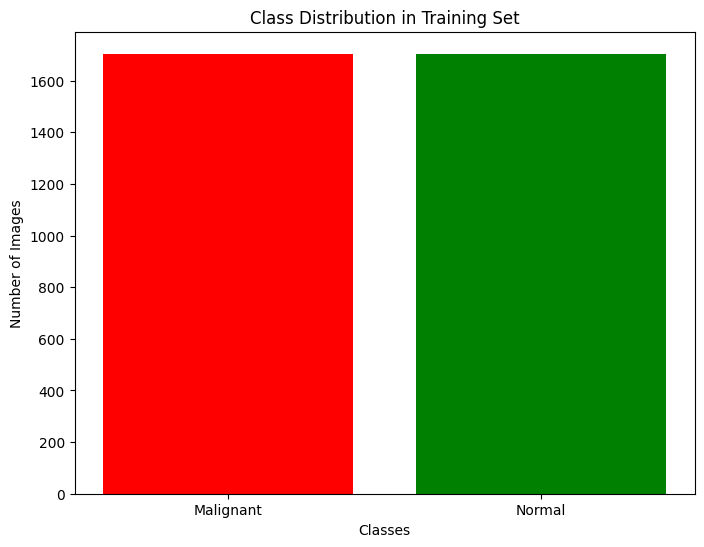

In [22]:
from collections import Counter
import matplotlib.pyplot as plt

labels = train_dataset.targets
label_counts = Counter(labels)

class_names = train_dataset.classes
class_labels = [class_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(class_labels, counts, color=['red', 'green'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

## 🖼️ Visualize Sample Images

### Why visualize?

**Quality Control:**
1. ✅ **Verify transforms work:** Are images properly enhanced?
2. ✅ **Check labels:** Do labels match images?
3. ✅ **Spot errors:** Are there any corrupted/wrong images?
4. ✅ **Understand data:** What does the model actually see?

### Function Breakdown:

**`show_batch()` function:**
- **Randomly samples** images from dataset
- **Unnormalizes** them (reverses normalization to display properly)
- **Displays in grid** (3 rows × 5 cols = 15 images)

### Why Unnormalize?
- Training images are normalized: `(pixel - 0.485) / 0.229`
- This makes pixel values negative/strange
- To display properly: `pixel = normalized * 0.229 + 0.485`
- Then clamp to [0, 1] range

### What to Check:
- ✅ CLAHE enhancement working? (good contrast)
- ✅ Images clearly visible?
- ✅ Labels match image content?
- ✅ Any obvious corrupted images?

**Pro Tip:** Run this multiple times to see different random samples!

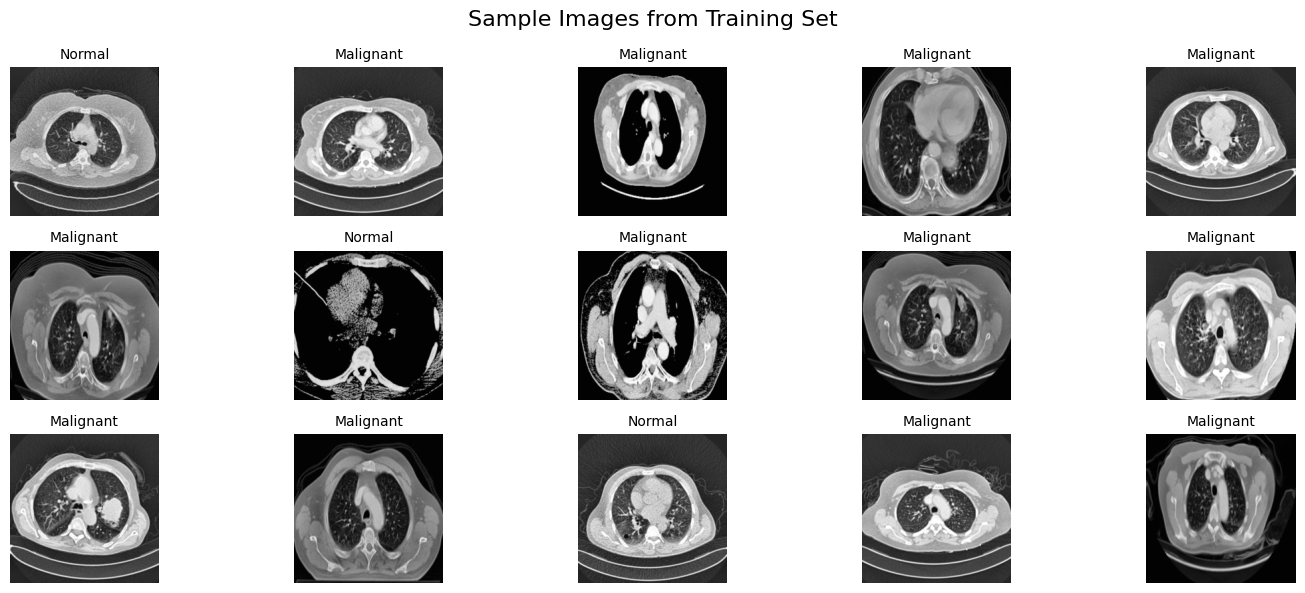

In [23]:
def show_batch(dataset, class_names, num_images=24):

    # Get images directly from dataset (much faster)
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)

    rows = 3
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # Unnormalize parameters
    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1)

    for i, ax in enumerate(axes.flatten()):
        if i < len(indices):
            img, label = dataset[indices[i]]

            # Unnormalize
            img = img * std + mean
            img = torch.clamp(img, 0, 1)

            # Convert to numpy
            img = img.numpy().transpose((1, 2, 0))

            ax.imshow(img, cmap='gray')
            ax.set_title(class_names[label], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle("Sample Images from Training Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call with dataset instead of dataloader
show_batch(train_dataset, train_dataset.classes)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

#         Architecture:
# - Conv2D(32) → ReLU → MaxPool → Dropout(0.25)
# - Conv2D(64) → ReLU → MaxPool → Dropout(0.25)
# - Conv2D(128) → ReLU → MaxPool → Dropout(0.3)
# - Flatten
# - Dense(512) → ReLU → Dropout(0.5)
# - Dense(2) → Softmax

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjusted for 224x224 input size

        self.fc2 = nn.Linear(512, 2)  # 2 output classes

        self.dropout25 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout5 = nn.Dropout(0.5)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout25(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout25(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout3(x)

        x = x.view(-1, 128 * 28 * 28)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)

        x = self.fc2(x)
        return x


In [26]:
model = SimpleCNN()

print(model)

dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
output = model(dummy_input)
print("✅ Model forward pass successful! Output shape:", output.shape)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Total parameters: {total_params}")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (dropout5): Dropout(p=0.5, inplace=False)
)
✅ Model forward pass successful! Output shape: torch.Size([1, 2])
✅ Total parameters: 51475010


In [27]:
print("⏳ Loading first batch (workers initializing, ~10-20 seconds)...")
images, labels = next(iter(train_loader))
print("✅ Workers ready! Future batches will be fast.")
print("Input batch shape:", images.shape)

⏳ Loading first batch (workers initializing, ~10-20 seconds)...
✅ Workers ready! Future batches will be fast.
Input batch shape: torch.Size([32, 3, 224, 224])


In [28]:
# test with real batch from dataloader

print("Testing model with real batch from dataloader...")

# Get a batch from the train_loader
images, labels = next(iter(train_loader))
print("Input batch shape:", images.shape)
print("Labels shape:", labels.shape)

model.eval()
with torch.no_grad():
    outputs = model(images)

print("Output batch shape:", outputs.shape)
print("✅ Model forward pass with real batch successful!")

Testing model with real batch from dataloader...
Input batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Output batch shape: torch.Size([32, 2])
✅ Model forward pass with real batch successful!


In [29]:
# Get probabilities (apply softmax)
probabilities = F.softmax(outputs, dim=1)
print(f"✅ Probabilities shape: {probabilities.shape}")
print(f"✅ First 5 predictions:")
print(probabilities[:5])

# Get predicted classes
predicted_classes = torch.argmax(probabilities, dim=1)
print(f"✅ Predicted classes: {predicted_classes[:10]}")
print(f"✅ True labels: {labels[:10]}")

✅ Probabilities shape: torch.Size([32, 2])
✅ First 5 predictions:
tensor([[0.5150, 0.4850],
        [0.5230, 0.4770],
        [0.5178, 0.4822],
        [0.5164, 0.4836],
        [0.5096, 0.4904]])
✅ Predicted classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
✅ True labels: tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 0])


In [30]:
# overfitting test

print("🧪 Overfitting test (can model memorize 1 batch?)...\n")

test_model = SimpleCNN()
test_model.train()

# Get a single batch
images, labels = next(iter(train_loader))

# simple training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(50):  # 50 epochs
    optimizer.zero_grad()

    outputs = test_model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        # Check accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / len(labels)
        print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Acc={accuracy:.2%}")

print("\n✅ Overfitting test completed.")

🧪 Overfitting test (can model memorize 1 batch?)...

Epoch 10: Loss=0.7017, Acc=40.62%
Epoch 20: Loss=0.6973, Acc=46.88%
Epoch 30: Loss=0.6914, Acc=56.25%
Epoch 40: Loss=0.6969, Acc=50.00%
Epoch 50: Loss=0.6698, Acc=65.62%

✅ Overfitting test completed.


In [32]:
%pip install torchinfo

In [33]:
# Install torchinfo if needed: pip install torchinfo
from torchinfo import summary

# Detailed model summary
print(summary(model, input_size=(1, 3, 224, 224),
              col_names=["input_size", "output_size", "num_params"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SimpleCNN                                [1, 3, 224, 224]          [1, 2]                    --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 32, 224, 224]         896
├─MaxPool2d: 1-2                         [1, 32, 224, 224]         [1, 32, 112, 112]         --
├─Dropout: 1-3                           [1, 32, 112, 112]         [1, 32, 112, 112]         --
├─Conv2d: 1-4                            [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
├─MaxPool2d: 1-5                         [1, 64, 112, 112]         [1, 64, 56, 56]           --
├─Dropout: 1-6                           [1, 64, 56, 56]           [1, 64, 56, 56]           --
├─Conv2d: 1-7                            [1, 64, 56, 56]           [1, 128, 56, 56]          73,856
├─MaxPool2d: 1-8                         [1, 128, 56, 56]          [1, 128, 28, 28]          --
├─Dropout: 1-9            

In [ ]:
# Save training history
import json

history['test_acc'] = test_acc
history['test_loss'] = test_loss
history['best_val_acc'] = best_val_acc
history['num_epochs'] = len(history['train_loss'])

with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

print("✅ Training history saved to 'training_history.json'")
print("✅ Best model saved to 'best_lung_cancer_model.pth'")
print("\n🎉 Training pipeline completed successfully!")

## 💾 Step 10: Save Training History

Save all metrics for future reference or further analysis.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("📊 CLASSIFICATION REPORT (Test Set)")
print("="*70)
print(classification_report(all_labels, all_preds, 
                          target_names=train_dataset.classes,
                          digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✅ Total Test Samples: {len(all_labels)}")
print(f"✅ Correct Predictions: {sum([1 for i in range(len(all_labels)) if all_labels[i] == all_preds[i]])}")
print(f"✅ Incorrect Predictions: {sum([1 for i in range(len(all_labels)) if all_labels[i] != all_preds[i]])}")

## 🎯 Step 9: Detailed Classification Report

**Per-class performance:**
- Precision: Of all predicted Malignant, how many were actually Malignant?
- Recall: Of all actual Malignant cases, how many did we catch?
- F1-Score: Harmonic mean of precision and recall

**Confusion Matrix:**
- Shows where model makes mistakes
- Diagonal = correct predictions
- Off-diagonal = errors

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, color='blue')
axes[0, 0].plot(history['val_loss'], label='Validation Loss', marker='s', linewidth=2, color='red')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2, color='green')
axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2, color='orange')
axes[0, 1].axhline(y=test_acc, color='purple', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_acc:.2f}%)')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Accuracy Comparison: Train vs Val vs Test', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Bar chart comparison
datasets = ['Train', 'Validation', 'Test']
accuracies = [history['train_acc'][-1], best_val_acc, test_acc]
colors = ['green', 'orange', 'purple']

axes[1, 0].bar(datasets, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (dataset, acc) in enumerate(zip(datasets, accuracies)):
    axes[1, 0].text(i, acc + 2, f'{acc:.2f}%', ha='center', fontsize=12, fontweight='bold')

# 4. Loss bar chart
losses = [history['train_loss'][-1], history['val_loss'][-1], test_loss]
axes[1, 1].bar(datasets, losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].set_title('Final Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (dataset, loss) in enumerate(zip(datasets, losses)):
    axes[1, 1].text(i, loss + 0.01, f'{loss:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 TRAINING SUMMARY")
print("="*70)
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}% (epoch {checkpoint['epoch']+1})")
print(f"\nFinal Metrics:")
print(f"  Train Accuracy:      {history['train_acc'][-1]:.2f}%")
print(f"  Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"  Test Accuracy:       {test_acc:.2f}%")
print(f"\n  Train Loss:          {history['train_loss'][-1]:.4f}")
print(f"  Validation Loss:     {history['val_loss'][-1]:.4f}")
print(f"  Test Loss:           {test_loss:.4f}")
print("="*70)

## 📊 Step 8: Comprehensive Performance Visualization

**All metrics in one view:**
- Train accuracy
- Validation accuracy  
- Test accuracy (final performance)

This helps compare how well the model performs across all three datasets.

In [ ]:
# Load best model
print("📂 Loading best model...")
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"   Validation Acc: {checkpoint['val_acc']:.2f}%")
print()

# Evaluate on test set
print("🧪 Evaluating on Test Set...")
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)

print("="*70)
print("📊 FINAL RESULTS")
print("="*70)
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🎯 Test Accuracy:           {test_acc:.2f}%")
print(f"📉 Test Loss:               {test_loss:.4f}")
print("="*70)

## 🧪 Step 7: Load Best Model & Evaluate on Test Set

**Why load best model?**
- The model at the end of training might not be the best
- We saved the model with highest validation accuracy
- Load it back for final evaluation

**Test Set Evaluation:**
- **NEVER** used during training
- Provides unbiased estimate of model performance
- Represents real-world performance

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2, color='green')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"📊 Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

## 📈 Step 6: Visualize Training History

**Training curves show:**
- **Loss curves** - Should decrease over time
  - Training loss: How well model fits training data
  - Validation loss: How well model generalizes
  
- **Accuracy curves** - Should increase over time
  - Training accuracy: Performance on training data
  - Validation accuracy: Performance on unseen data

**What to look for:**
- ✅ **Good:** Both train and val improve together
- ⚠️ **Overfitting:** Train improves but val plateaus/worsens
- ⚠️ **Underfitting:** Both train and val are poor

In [ ]:
# Initialize tracking variables
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0

print("="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print()

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, MODEL_SAVE_PATH)
        print(f"  ✅ Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{PATIENCE})")
    
    print()
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"🛑 Early stopping triggered! No improvement for {PATIENCE} epochs.")
        break

print("="*70)
print("✅ TRAINING COMPLETED!")
print("="*70)
print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"💾 Best model saved to: {MODEL_SAVE_PATH}")

## 🏋️ Step 5: Main Training Loop

**What happens during training:**

1. **Each Epoch:**
   - Train on entire training set
   - Validate on validation set
   - Update learning rate if needed
   - Save model if validation accuracy improves
   
2. **Early Stopping:**
   - Tracks best validation accuracy
   - Stops if no improvement for PATIENCE epochs
   - Prevents overfitting and saves time
   
3. **Model Checkpointing:**
   - Saves model whenever validation accuracy improves
   - Ensures we keep the best performing model
   
4. **Metrics Tracking:**
   - Records loss and accuracy for each epoch
   - Used for plotting learning curves later

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch
    Returns: average loss and accuracy
    """
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for images, labels in pbar:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model
    Returns: average loss and accuracy
    """
    model.eval()  # Set model to evaluation mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        
        for images, labels in pbar:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Training and validation functions defined")

## 🎯 Step 4: Training & Validation Functions

**Training Function:**
- Iterates through training batches
- Forward pass → Calculate loss → Backward pass → Update weights
- Tracks loss and accuracy
- Uses `model.train()` mode (enables dropout)

**Validation Function:**
- Evaluates on validation set
- No gradient computation (`torch.no_grad()`)
- Uses `model.eval()` mode (disables dropout)
- Returns loss and accuracy for monitoring

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',           # Minimize validation loss
    factor=0.5,           # Reduce LR by half
    patience=LR_PATIENCE, # Wait 5 epochs before reducing
    verbose=True          # Print when LR is reduced
)

print("✅ Loss function: CrossEntropyLoss")
print("✅ Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print("✅ Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")

## 🔧 Step 3: Loss Function & Optimizer

**Loss Function: CrossEntropyLoss**
- Standard for multi-class classification
- Combines LogSoftmax + NLLLoss
- Automatically handles class probabilities

**Optimizer: Adam**
- Adaptive learning rate for each parameter
- Combines benefits of RMSprop + Momentum
- Works well for most deep learning tasks

**Learning Rate Scheduler: ReduceLROnPlateau**
- Monitors validation loss
- Reduces LR by factor of 0.5 when loss plateaus
- Helps model converge better

In [ ]:
# Training hyperparameters
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10  # Early stopping patience
LR_PATIENCE = 5  # Learning rate scheduler patience
MODEL_SAVE_PATH = 'best_lung_cancer_model.pth'

print("📋 Training Configuration:")
print(f"   Max Epochs: {NUM_EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Early Stopping Patience: {PATIENCE}")
print(f"   LR Scheduler Patience: {LR_PATIENCE}")
print(f"   Model Save Path: {MODEL_SAVE_PATH}")

## ⚙️ Step 2: Training Hyperparameters

**Key hyperparameters explained:**

- **NUM_EPOCHS = 50** - Maximum training epochs
  - Model will train for up to 50 epochs
  - Early stopping may stop earlier if no improvement
  
- **LEARNING_RATE = 0.001** - Initial learning rate
  - Controls how much to update weights
  - 0.001 is a good starting point for Adam optimizer
  - Scheduler will reduce this if validation plateaus
  
- **PATIENCE = 10** - Early stopping patience
  - Stops if validation accuracy doesn't improve for 10 epochs
  - Prevents wasting time on overtraining
  
- **LR_PATIENCE = 5** - Learning rate scheduler patience
  - Reduces LR if validation loss doesn't improve for 5 epochs
  - Helps escape local minima

In [ ]:
# Device configuration - Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

if torch.cuda.is_available():
    print(f"⚡ GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: Running on CPU. Training will be MUCH slower!")
    
# Move model to device
model = SimpleCNN().to(device)
print(f"✅ Model moved to {device}")

## 🖥️ Step 1: Device Configuration (GPU Setup)

# 🚀 **Training Pipeline - Full Mode**

## 📋 Training Configuration

In this section, we'll:
1. ✅ Configure GPU device
2. ✅ Set up optimizer and loss function
3. ✅ Implement training loop with validation
4. ✅ Track metrics (loss & accuracy)
5. ✅ Add early stopping (prevent overtraining)
6. ✅ Save best model checkpoint
7. ✅ Visualize training progress
8. ✅ Evaluate on test set

---

## 🎯 Strategy for Maximizing Accuracy:
- **Learning Rate Scheduler** - Reduce LR when validation loss plateaus
- **Early Stopping** - Stop when validation doesn't improve
- **Model Checkpointing** - Save best model based on validation accuracy
- **Data Augmentation** - Already done (offline + online RandomCrop)
- **Dropout** - Already in model (0.25, 0.3, 0.5)
- **Batch Normalization** - Could add (optional improvement)